In [1]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Cargar datos
df = pd.read_csv("dstn_6.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# Pivotear: filas = productos, columnas = fechas
df_pivot = df.pivot_table(index='product_id', columns='periodo', values='tn', aggfunc='sum').fillna(0)

# Asegurar formato [n_series, n_timestamps, 1]
X = df_pivot.values[:, :, np.newaxis]

# Normalizar (opcional pero recomendado para DTW)
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

# Clustering con DTW
n_clusters = 5  # podés cambiarlo según el caso
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = km_dtw.fit_predict(X_scaled)

# Guardar resultado
df_clusters = pd.DataFrame({
    'product_id': df_pivot.index,
    'cluster_dtw': labels
})
df_clusters.to_csv("dtw_clusters6.csv", index=False)
print("✅ Archivo dtw_clusters6.csv generado correctamente.")


c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 

✅ Archivo dtw_clusters6.csv generado correctamente.


In [3]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datasets
df = pd.read_csv("dstn_6.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clusters6.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

# Conversión a float32 explícita
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 9. Entrenar modelo
mejores_params = {
    'n_estimators': 237,
    'learning_rate': 0.1259446562377271,
    'max_depth': 11,
    'num_leaves': 174,
    'subsample': 0.6696570762181164,
    'colsample_bytree': 0.7180821258995593,
    'random_state': 42,
    'min_data_in_leaf': 45,
    'reg_alpha': 1.8056442720292916,
    'reg_lambda': 2.831897858432968,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 10. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 11. Preparar predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Conversión a float32 para predicción
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
feb_df.fillna(0, inplace=True)  # ⬅️ esta línea te faltaba
X_feb = feb_df[features].astype('float32')


# 12. Predicción
feb_df['tn_predicho'] = modelo.predict(X_feb)
feb_df['tn_predicho_ajustada'] = 1 * feb_df['tn_predicho'] + 0 * feb_df['febrero_hist']

# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_dstn6.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn6.csv")


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 6936, number of used features: 10
[LightGBM] [Info] Start training from score 14.281926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\waldo\AppData\Local\Temp\ipykernel_22992\2346832005.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feb_df.fillna(0, inplace=True)  # ⬅️ esta línea te faltaba


In [4]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_dstn6.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("dstn_6.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo           tn
1  2017-02-01  2960.697140
2  2017-03-01  3825.686750
3  2017-04-01  3264.475770
4  2017-05-01  3422.662840
5  2017-06-01  3407.227790
6  2017-07-01  2766.006690
7  2017-08-01  3240.361030
8  2017-09-01  3902.583190
9  2017-10-01  4292.749210
10 2017-11-01  4046.574630
11 2017-12-01  2888.618020
12 2018-01-01  2425.212660
13 2018-02-01  2807.635240
14 2018-03-01  4159.540730
15 2018-04-01  3102.425650
16 2018-05-01  3596.511900
17 2018-06-01  3159.996910
18 2018-07-01  2868.557460
19 2018-08-01  3192.206900
20 2018-09-01  2902.674760
21 2018-10-01  2975.840060
22 2018-11-01  2897.390990
23 2018-12-01  2079.386340
24 2019-01-01  2662.450800
25 2019-02-01  2876.235320
26 2019-03-01  2937.873710
27 2019-04-01  3042.210450
28 2019-05-01  3015.092840
29 2019-06-01  3023.914970
30 2019-07-01  2949.061280
31 2019-08-01  2396.829740
32 2019-09-01  3409.850950
33 2019-10-01  3054.888630
34 2019-11-01 


📌 Importancia de variables:
               feature  importancia
2                lag_3         1150
4      media_movil_12m         1142
8      delta_ma12_lag1         1046
0                lag_1         1040
1                lag_2         1008
6      delta_lag1_lag2          942
5        var_lag1_lag2          664
3                  mes          579
9          cluster_dtw          313
7  delta_rel_lag1_lag2          297


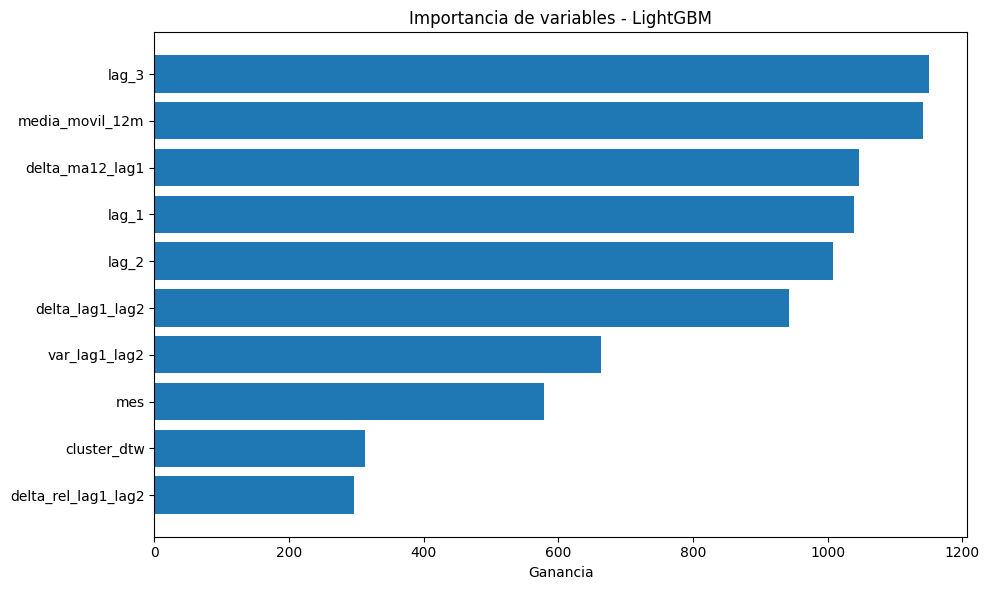

In [5]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()


In [6]:
# 14. Comparación contra histórico total de febreros anteriores
df_feb = df[
    (df['periodo'].dt.month == 2) &
    (df['periodo'].dt.year.isin([2017, 2018, 2019]))
]

total_feb_2017 = df_feb[df_feb['periodo'].dt.year == 2017]['tn'].sum()
total_feb_2018 = df_feb[df_feb['periodo'].dt.year == 2018]['tn'].sum()
total_feb_2019 = df_feb[df_feb['periodo'].dt.year == 2019]['tn'].sum()

promedio_total_feb = (total_feb_2017 + total_feb_2018 + total_feb_2019) / 3

# 15. Comparación con predicción
comparacion = feb_df[['product_id', 'tn_predicho', 'tn_predicho_ajustada']].copy()

total_modelo = comparacion['tn_predicho'].sum()
total_ajustada = comparacion['tn_predicho_ajustada'].sum()

print("\n🔎 Comparación de totales:")
print(f"📉 Predicción solo modelo...........: {total_modelo:,.2f} tn")
print(f"⚖️  Predicción ajustada (1/0)......: {total_ajustada:,.2f} tn")
print(f"📜 Promedio histórico total febreros (2017–2019): {promedio_total_feb:,.2f} tn")



🔎 Comparación de totales:
📉 Predicción solo modelo...........: 7,651.44 tn
⚖️  Predicción ajustada (1/0)......: 7,651.44 tn
📜 Promedio histórico total febreros (2017–2019): 2,881.52 tn


📈 R² en diciembre 2019: 0.6794
📉 Sesgo promedio: 0.1535


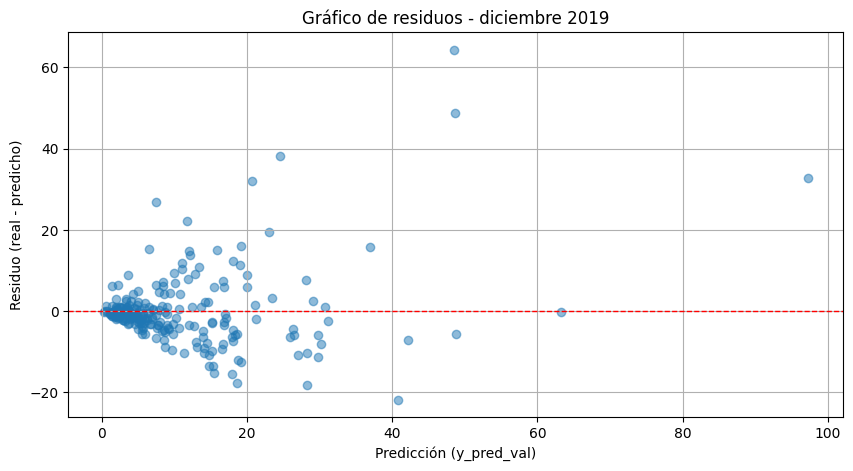

In [7]:
#DESDE ACÁ 1

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Calcular residuos
residuos = y_val - y_pred_val

# Calcular R² y sesgo promedio
r2 = r2_score(y_val, y_pred_val)
sesgo_promedio = np.mean(residuos)

# Mostrar métricas
print(f"📈 R² en diciembre 2019: {r2:.4f}")
print(f"📉 Sesgo promedio: {sesgo_promedio:.4f}")

# Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_val, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción (y_pred_val)')
plt.ylabel('Residuo (real - predicho)')
plt.title('Gráfico de residuos - diciembre 2019')
plt.grid(True)
plt.show()


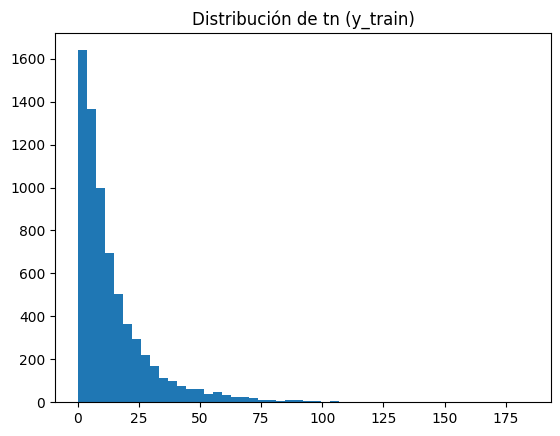

In [8]:
#DESDE ACÁ 2
import matplotlib.pyplot as plt
plt.hist(y_train, bins=50)
plt.title("Distribución de tn (y_train)")
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 6936, number of used features: 10
[LightGBM] [Info] Start training from score 2.274870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

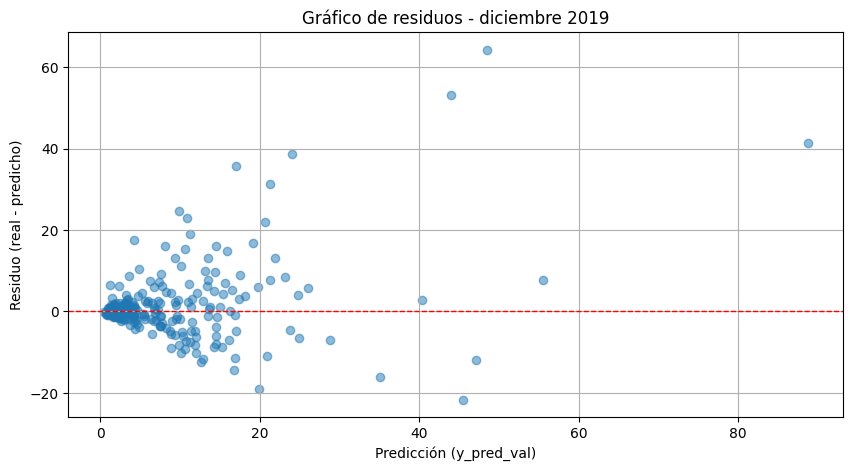

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn6_1.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_22992\1942505729.py:140: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feb_df.fillna(0, inplace=True)


In [9]:
#DESDE ACÁ 3
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Cargar datasets
df = pd.read_csv("dstn_6.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clusters6.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 🔄 Log-transform del target
y_train_log = np.log1p(y_train)

# 9. Entrenar modelo
mejores_params = {
    'n_estimators': 237,
    'learning_rate': 0.1259446562377271,
    'max_depth': 11,
    'num_leaves': 174,
    'subsample': 0.6696570762181164,
    'colsample_bytree': 0.7180821258995593,
    'random_state': 42,
    'min_data_in_leaf': 45,
    'reg_alpha': 1.8056442720292916,
    'reg_lambda': 2.831897858432968,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train_log)

# 🔄 Predicción log → escala original
y_pred_val_log = modelo.predict(X_val)
y_pred_val = np.expm1(y_pred_val_log)

# ⏱️ Métricas
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
residuos = y_val - y_pred_val
sesgo = np.mean(residuos)

print(f"📊 MAE en diciembre 2019: {mae:.2f}")
print(f"📈 R² en diciembre 2019: {r2:.4f}")
print(f"📉 Sesgo promedio: {sesgo:.4f}")

# 📉 Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_val, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción (y_pred_val)')
plt.ylabel('Residuo (real - predicho)')
plt.title('Gráfico de residuos - diciembre 2019')
plt.grid(True)
plt.savefig("grafico_residuos_diciembre2019.png", dpi=300)
plt.show()

# 11. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
feb_df.fillna(0, inplace=True)

X_feb = feb_df[features].astype('float32')

# 🔄 Predicción log → original
feb_df['tn_predicho'] = np.expm1(modelo.predict(X_feb))
feb_df['tn_predicho_ajustada'] = feb_df['tn_predicho']  # sin mezcla con histórico por ahora

# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_dstn6_1.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn6_1.csv")


In [10]:
#DESDE ACÁ 4
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_dstn6_1.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("dstn_6.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo            tn
1  2017-02-01  2.960697e+03
2  2017-03-01  3.825687e+03
3  2017-04-01  3.264476e+03
4  2017-05-01  3.422663e+03
5  2017-06-01  3.407228e+03
6  2017-07-01  2.766007e+03
7  2017-08-01  3.240361e+03
8  2017-09-01  3.902583e+03
9  2017-10-01  4.292749e+03
10 2017-11-01  4.046575e+03
11 2017-12-01  2.888618e+03
12 2018-01-01  2.425213e+03
13 2018-02-01  2.807635e+03
14 2018-03-01  4.159541e+03
15 2018-04-01  3.102426e+03
16 2018-05-01  3.596512e+03
17 2018-06-01  3.159997e+03
18 2018-07-01  2.868557e+03
19 2018-08-01  3.192207e+03
20 2018-09-01  2.902675e+03
21 2018-10-01  2.975840e+03
22 2018-11-01  2.897391e+03
23 2018-12-01  2.079386e+03
24 2019-01-01  2.662451e+03
25 2019-02-01  2.876235e+03
26 2019-03-01  2.937874e+03
27 2019-04-01  3.042210e+03
28 2019-05-01  3.015093e+03
29 2019-06-01  3.023915e+03
30 2019-07-01  2.949061e+03
31 2019-08-01  2.396830e+03
32 2019-09-01  3.409851e+03
33 2019-

📊 Error por decil histórico:
   decil_hist   tn_predicho  febrero_hist     error_abs  error_relativo
0           1  2.418417e+00      0.905332  1.671112e+00    3.463572e+04
1           2  3.739805e+00      2.263643  2.490517e+00    1.176367e+00
2           3  4.326084e+00      3.410208  1.976090e+00    5.604278e-01
3           4  4.039422e+00      4.950167  1.829520e+00    3.720383e-01
4           5  6.789198e+00      6.999595  3.297074e+00    4.581012e-01
5           6  1.010706e+01      9.223080  4.117363e+00    4.660156e-01
6           7  1.716429e+48     12.491816  1.716429e+48    1.395438e+47
7           8  1.443558e+01     17.523310  6.312726e+00    3.555711e-01
8           9  1.680865e+01     23.787046  7.967311e+00    3.304574e-01
9          10  2.592285e+01     41.142863  1.542267e+01    3.831814e-01

📊 Error por cluster DTW:
   cluster_dtw   tn_predicho  febrero_hist     error_abs  error_relativo
0            0  1.171373e+01     19.458955  8.520143e+00    5.813436e-01
1      

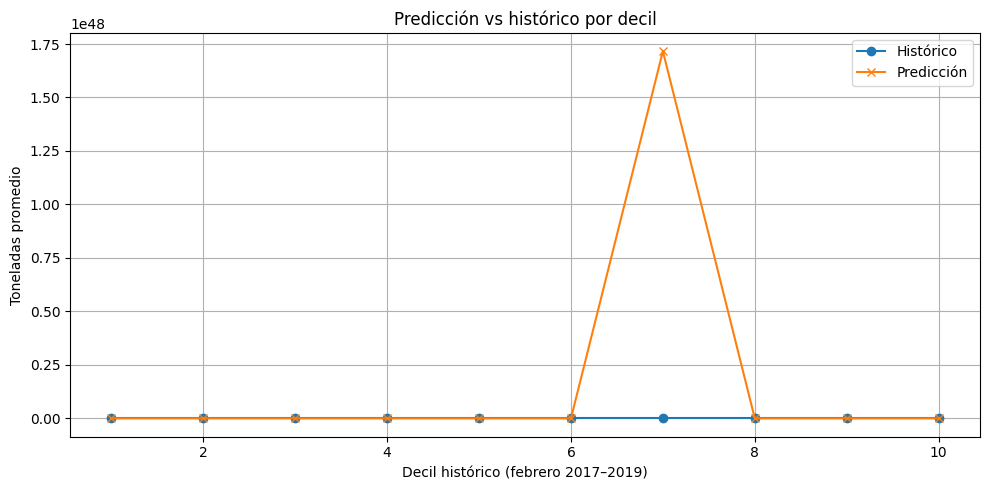

In [11]:
#DESDE ACÁ 5

# ===============================
# ANÁLISIS POR DECIL Y CLUSTER DTW
# ===============================

import matplotlib.pyplot as plt

# 1. Deciles históricos (1 = bajo, 10 = alto)
feb_df['decil_hist'] = pd.qcut(feb_df['febrero_hist'], q=10, labels=False, duplicates='drop') + 1

# 2. Métricas por decil
decil_stats = feb_df.groupby('decil_hist').agg(
    tn_predicho=('tn_predicho', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("📊 Error por decil histórico:")
print(decil_stats)

# 3. Métricas por cluster DTW
cluster_stats = feb_df.groupby('cluster_dtw').agg(
    tn_predicho=('tn_predicho', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("\n📊 Error por cluster DTW:")
print(cluster_stats)

# 4. Gráfico comparativo por decil
plt.figure(figsize=(10,5))
plt.plot(decil_stats['decil_hist'], decil_stats['febrero_hist'], label='Histórico', marker='o')
plt.plot(decil_stats['decil_hist'], decil_stats['tn_predicho'], label='Predicción', marker='x')
plt.xlabel('Decil histórico (febrero 2017–2019)')
plt.ylabel('Toneladas promedio')
plt.title('Predicción vs histórico por decil')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("comparacion_por_decil.png", dpi=300)
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 6936, number of used features: 10
[LightGBM] [Info] Start training from score 2.274870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

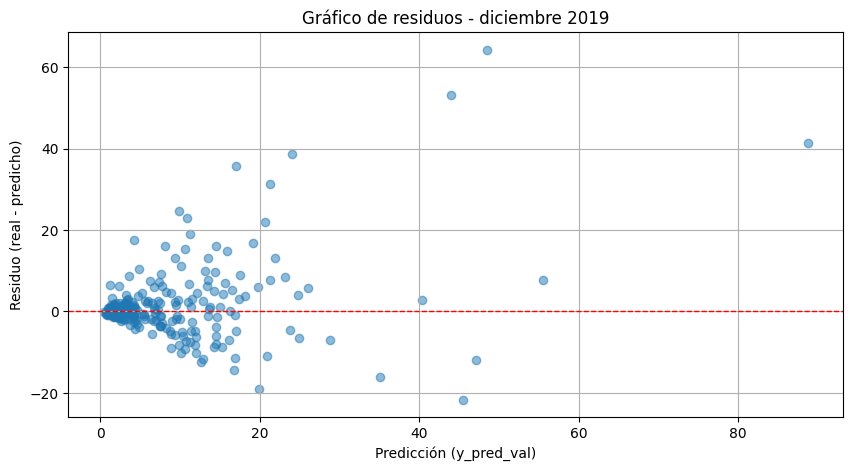

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn6_5.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_2788\3424331150.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feb_df.fillna(0, inplace=True)


In [5]:
#DESDE ACÁ 6
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Cargar datasets
df = pd.read_csv("dstn_6.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clusters6.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 🔄 Log-transform del target
y_train_log = np.log1p(y_train)

# 9. Entrenar modelo
mejores_params = {
    'n_estimators': 237,
    'learning_rate': 0.1259446562377271,
    'max_depth': 11,
    'num_leaves': 174,
    'subsample': 0.6696570762181164,
    'colsample_bytree': 0.7180821258995593,
    'random_state': 42,
    'min_data_in_leaf': 45,
    'reg_alpha': 1.8056442720292916,
    'reg_lambda': 2.831897858432968,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train_log)

# 🔄 Predicción log → escala original
y_pred_val_log = modelo.predict(X_val)
y_pred_val_log = np.clip(y_pred_val_log, 0, 12)  # ⚠️ capado a valores razonables
y_pred_val = np.expm1(y_pred_val_log)
y_pred_val = np.where(np.isfinite(y_pred_val), y_pred_val, 0)

# ⏱️ Métricas
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
residuos = y_val - y_pred_val
sesgo = np.mean(residuos)

print(f"📊 MAE en diciembre 2019: {mae:.2f}")
print(f"📈 R² en diciembre 2019: {r2:.4f}")
print(f"📉 Sesgo promedio: {sesgo:.4f}")

# 📉 Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_val, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción (y_pred_val)')
plt.ylabel('Residuo (real - predicho)')
plt.title('Gráfico de residuos - diciembre 2019')
plt.grid(True)
plt.savefig("grafico_residuos_diciembre2019.png", dpi=300)
plt.show()

# 11. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
feb_df.fillna(0, inplace=True)

X_feb = feb_df[features].astype('float32')

# 🔄 Predicción log → original (con clipping fuerte)
pred_log = modelo.predict(X_feb)
pred_log = np.where(np.isfinite(pred_log), pred_log, 0)
pred_log = np.clip(pred_log, a_min=0, a_max=12)
pred = np.expm1(pred_log)
pred = np.where((np.isfinite(pred)) & (pred < 1e5), pred, 0)

feb_df['tn_predicho_modelo'] = pred

# 🔄 Combinación con histórico: 60% modelo + 30% promedio febrero 2017–2019
feb_df['tn_predicho_ajustada'] = (
    0.5 * feb_df['tn_predicho_modelo'] + 0.5 * feb_df['febrero_hist']
)

# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_dstn6_5.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn6_5.csv")


In [2]:
#DESDE ACÁ 7
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_dstn6_4.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("dstn_6.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo           tn
1  2017-02-01  2960.697140
2  2017-03-01  3825.686750
3  2017-04-01  3264.475770
4  2017-05-01  3422.662840
5  2017-06-01  3407.227790
6  2017-07-01  2766.006690
7  2017-08-01  3240.361030
8  2017-09-01  3902.583190
9  2017-10-01  4292.749210
10 2017-11-01  4046.574630
11 2017-12-01  2888.618020
12 2018-01-01  2425.212660
13 2018-02-01  2807.635240
14 2018-03-01  4159.540730
15 2018-04-01  3102.425650
16 2018-05-01  3596.511900
17 2018-06-01  3159.996910
18 2018-07-01  2868.557460
19 2018-08-01  3192.206900
20 2018-09-01  2902.674760
21 2018-10-01  2975.840060
22 2018-11-01  2897.390990
23 2018-12-01  2079.386340
24 2019-01-01  2662.450800
25 2019-02-01  2876.235320
26 2019-03-01  2937.873710
27 2019-04-01  3042.210450
28 2019-05-01  3015.092840
29 2019-06-01  3023.914970
30 2019-07-01  2949.061280
31 2019-08-01  2396.829740
32 2019-09-01  3409.850950
33 2019-10-01  3054.888630
34 2019-11-01 

📊 Error por decil histórico:
   decil_hist  tn_predicho  febrero_hist  error_abs  error_relativo
0           1     1.813183      0.905332   1.002667    20781.434367
1           2     3.163226      2.263643   1.480425        0.699789
2           3     3.959734      3.410208   1.185654        0.336257
3           4     4.403720      4.950167   1.097712        0.223223
4           5     6.873357      6.999595   1.978244        0.274861
5           6     9.753468      9.223080   2.470418        0.279609
6           7    10.624607     12.491816   3.005128        0.243354
7           8    15.670671     17.523310   3.787636        0.213343
8           9    19.600009     23.787046   4.780387        0.198274
9          10    32.010856     41.142863   9.253603        0.229909

📊 Error por cluster DTW:
   cluster_dtw  tn_predicho  febrero_hist  error_abs  error_relativo
0            0    14.811818     19.458955   5.112086        0.348806
1            1     7.974892      9.538052   2.609158     66

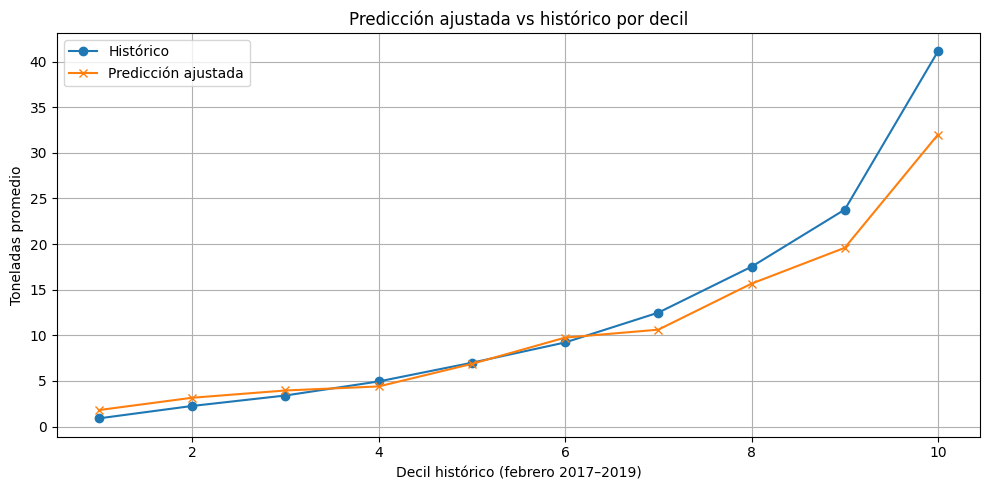

In [3]:
#DESDE ACÁ 8

# 1. Deciles históricos (1 = bajo, 10 = alto)
feb_df['decil_hist'] = pd.qcut(feb_df['febrero_hist'], q=10, labels=False, duplicates='drop') + 1

# 2. Métricas por decil
decil_stats = feb_df.groupby('decil_hist').agg(
    tn_predicho=('tn_predicho_ajustada', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("📊 Error por decil histórico:")
print(decil_stats)

# 3. Métricas por cluster DTW
cluster_stats = feb_df.groupby('cluster_dtw').agg(
    tn_predicho=('tn_predicho_ajustada', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("\n📊 Error por cluster DTW:")
print(cluster_stats)

# 4. Gráfico comparativo por decil
plt.figure(figsize=(10,5))
plt.plot(decil_stats['decil_hist'], decil_stats['febrero_hist'], label='Histórico', marker='o')
plt.plot(decil_stats['decil_hist'], decil_stats['tn_predicho'], label='Predicción ajustada', marker='x')
plt.xlabel('Decil histórico (febrero 2017–2019)')
plt.ylabel('Toneladas promedio')
plt.title('Predicción ajustada vs histórico por decil')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("comparacion_por_decil_ajustada.png", dpi=300)
plt.show()



📋 Comparativo global:
🔍 Modelo puro: MAE=5.02, R²=0.6269, Sesgo=2.50
🔍 Predicción ajustada: MAE=3.01, R²=0.8657, Sesgo=1.50


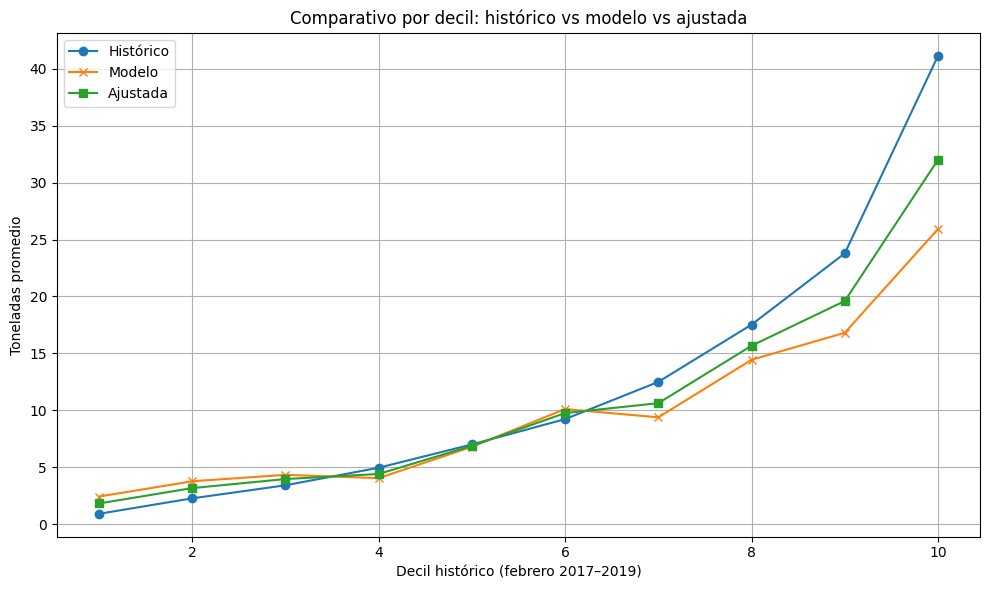

In [4]:
#DESDE ACÁ 9

# ===============================
# COMPARATIVO MODELO VS AJUSTADA
# ===============================

# 1. Métricas generales
def resumen_error(real, pred, nombre):
    mae = mean_absolute_error(real, pred)
    r2 = r2_score(real, pred)
    sesgo = np.mean(real - pred)
    print(f"🔍 {nombre}: MAE={mae:.2f}, R²={r2:.4f}, Sesgo={sesgo:.2f}")

print("\n📋 Comparativo global:")
resumen_error(feb_df['febrero_hist'], feb_df['tn_predicho_modelo'], "Modelo puro")
resumen_error(feb_df['febrero_hist'], feb_df['tn_predicho_ajustada'], "Predicción ajustada")

# 2. Comparación gráfica por decil
feb_df['decil_hist'] = pd.qcut(feb_df['febrero_hist'], q=10, labels=False, duplicates='drop') + 1

comparativo = feb_df.groupby('decil_hist').agg(
    febrero_hist=('febrero_hist', 'mean'),
    modelo=('tn_predicho_modelo', 'mean'),
    ajustada=('tn_predicho_ajustada', 'mean')
).reset_index()

# 3. Plot comparativo
plt.figure(figsize=(10, 6))
plt.plot(comparativo['decil_hist'], comparativo['febrero_hist'], label='Histórico', marker='o')
plt.plot(comparativo['decil_hist'], comparativo['modelo'], label='Modelo', marker='x')
plt.plot(comparativo['decil_hist'], comparativo['ajustada'], label='Ajustada', marker='s')
plt.xlabel('Decil histórico (febrero 2017–2019)')
plt.ylabel('Toneladas promedio')
plt.title('Comparativo por decil: histórico vs modelo vs ajustada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("comparativo_modelo_vs_ajustada_por_decil.png", dpi=300)
plt.show()
